# Test of Bayesian Markov-Chain Monte-Carlo Method with ARCS Data

This data was supplied by Garrett Granroth from the SNS / Oak Ridge National Laboratory.

The data reduction was done in Mantid, preserving events, and the events are imported from a nexus autoreduced file.  
As such, the events do have some histogram artefacts from the way that the weights are computed.
I'm not sure if this can be entirely avoided with pixelated detectors, but in an ideal world we'd compute the event weighting factors without using histograms at all.

/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/201616-exported.nxs
EMAnalyser object created with 2623437 weighted events in range -661.5 - 661.5
Calculating KDE
   - linear scale
nx 224
slice size 0.5880000000000001


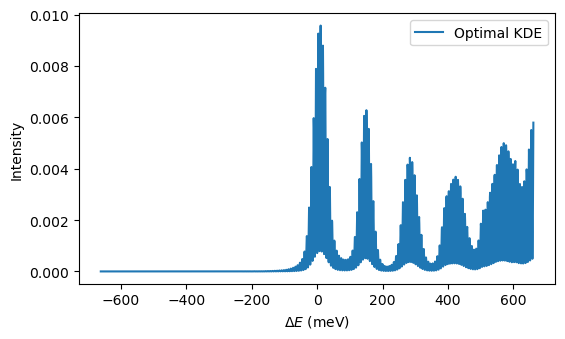

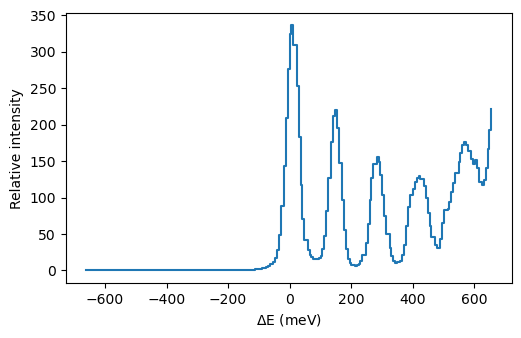

In [120]:
import h5py
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("error")

# Uncomment the following to make random things reproducable
# (useful for paper figures etc)
# In theory this should work, but for some reason the later analyses are shifting around

RANDOM_SEED = 0
np.random.seed(seed=RANDOM_SEED)

import lmfit 

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform

import copy


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, importlib lets us change the source and force reload of the emtk package.
# However, whilst the error reporting line number is right, the printout of
# the offending source code is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def loadRawARCS(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus"
    stem="/ARCS_"
    tail=".nxs.h5"

    filename = ldpath + stem + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')

    print( list(f.keys()) )

    entr = f['entry']
    b30 = entr['bank30_events']

    
    print( b30 )
    print( list(b30.keys()) )

    print(b30['event_id'])

    f.close()


def listkeys(obj):
    print( list( obj.keys()) )

def loadARCSmd(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/"
    tail="-exported.nxs"

    filename = ldpath + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')
    ws = f['MDEventWorkspace']
    cs = ws['coordinate_system']
    ed = ws['event_data']['event_data']
    bs = ws['box_structure']
    ex = ws['experiment0']
    pr = ws['process']
    vn = ws['visual_normalization']

    #for i in range(7):
    #    ed1 = ed[:,i]
    #    fig,ax = plt.subplots()
    #    plt.plot(ed1)

    dE = ed[:,6]
    wt = ed[:,0]

    #fig,ax = plt.subplots()
    #plt.plot(dE, wt)

    # Filter out zeros

    mask = wt > 0.0

    keepdE = dE[mask]
    keepwt = wt[mask]

    return keepdE, keepwt







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

    

def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    t1 = norm.cdf(x1, loc=mu, scale=sigma)
    t2 = norm.cdf(x2, loc=mu, scale=sigma)
    intg = t1 - t2

    return np.absolute(intg)




evs, wts = loadARCSmd(201616)

ema1 = ema.EMAnalyser(evs, wts)

# We need a full data KDE for later...
ema1.plot_kde(log=False, loglog=False, xlabel='$\Delta E$ (meV)')

#ema1.plot_histogram(loglog=False, log=False, xlabel='meV')

# Manually replot and save histo figure for a paper
bn=ema1.optimal_n_bins()
hst = np.histogram(ema1.data, bins=bn, weights=ema1.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.savefig('arcsFigs/arcs_data_histo.png', dpi=600, bbox_inches='tight')
plt.show()


Least squares model function defined.
['amplitude', 'elmu', 'mu1', 'mu2', 'mu3', 'mu4', 'mubg1', 'mubg2', 'elsigma', 's1', 's2', 's3', 's4', 'sbg1', 'sbg2', 'm1', 'm2', 'm3', 'm4', 'mbg1', 'mbg2']
[1.03166976e+00 7.83319976e+00 1.45695047e+02 2.81254328e+02
 4.14035526e+02 5.52327378e+02 6.99999691e+02 2.30190791e-02
 1.86422670e+01 1.99165093e+01 2.21066916e+01 2.75136714e+01
 2.79613790e+01 1.16801601e+02 4.02817313e+01 1.90420268e-01
 1.40207127e-01 1.18191129e-01 1.18351136e-01 7.89817013e-02
 2.74781599e-01]
[4.61820689e-02 6.77407450e+00 2.42608681e+00 3.35152531e+00
 5.96478512e+00 1.22412580e+01 3.09337227e+02 3.62514381e+01
 3.89449285e+00 2.56288306e+00 3.38997008e+00 7.33200369e+00
 1.78787566e+01 5.13883390e+13 1.76492899e+02 2.18159185e-01
 1.82600064e-02 1.60267612e-02 4.38465615e-02 9.72543769e-02
 1.23466682e-01]


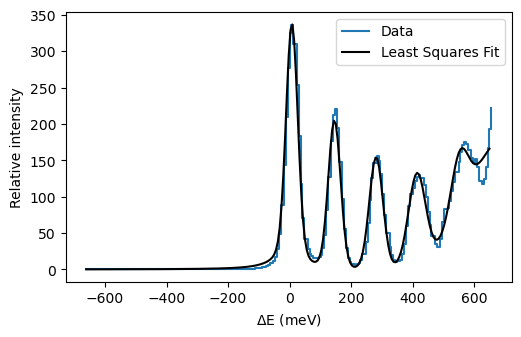

In [121]:
def big_lse_pdf(x, amplitude, elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(x, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(x, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(x, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(x, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(x, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(x, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(x, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)
    
    sol = amplitude * (el + l1 + l2 + l3 + l4 + bg1 + bg2)
    
    return sol


ema1.set_lse_function(big_lse_pdf)


ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    elmu = dict(value=10.0, min=-100.0, max=100.0),\
    mu1 = dict(value=150.0, min=100.0, max=200.0),\
    mu2 = dict(value=280.0, min=200.0, max=350.0),\
    mu3 = dict(value=420.0, min=350.0, max=450.0),\
    mu4 = dict(value=560.0, min=500.0, max=620.0),\
    mubg1=dict(value=620.0, min=600.0, max=700.0),\
    mubg2=dict(value=140.0, min=0.0, max=200.0),\

    elsigma = dict(value=20.0, min=10.0, max=100.0),\
    s1 = dict(value=30.0, min=10.0, max=100.0),\
    s2 = dict(value=30.0, min=10.0, max=100.0),\
    s3 = dict(value=30.0, min=10.0, max=100.0),\
    s4 = dict(value=30.0, min=10.0, max=100.0),\
    sbg1=dict(value=100.0, min=100.0, max=250.0),\
    sbg2=dict(value=20.0, min=10.0, max=250.0),\
    m1=dict(value=0.3, min=0.0, max = 1.0),\
    m2=dict(value=0.2, min=0.0, max = 1.0),\
    m3=dict(value=0.15, min=0.0, max = 1.0),\
    m4=dict(value=0.1, min=0.0, max = 1.0),\
    mbg1=dict(value=0.1, min=0.0, max=1.0),\
    mbg2=dict(value=0.1, min=0.0, max=1.0)
)

lse_starting_parameters = copy.deepcopy(ema1.least_squares_parameters)


#ema1.plot_LSE_initial(loglog=False, log=False)

ema1.lse_fit()
#ema1.plot_LSE_fit(loglog=False, log=False, xlabel='meV', save="/Users/phillipbentley/Code/python/mle/arcs_lse_fit.png")

pnams = ema1.get_lse_param_names()
print(pnams)

pvals = ema1.get_lse_param_values()
print(pvals)

detailed_fit_params = pvals

psigs = ema1.get_lse_param_errors()
print(psigs)

detailed_fit_sigmas = psigs

# Manually replot and save figure for a paper
bn=ema1.optimal_n_bins()
hst = np.histogram(ema1.data, bins=bn, weights=ema1.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post', label='Data')
nhy = hy.size
shy = np.sum(hy)
nly = ema1.lse_result.best_fit.size
sly = np.sum(ema1.lse_result.best_fit)

scl = shy * nly / (nhy * sly)

ax.plot(ema1.histx, scl*ema1.lse_result.best_fit, color='black', label='Least Squares Fit')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.legend()
plt.savefig('arcsFigs/arcs_data_lse.png', dpi=600, bbox_inches='tight')
plt.show()


In [122]:
# This is needed once, because the first few points are strange
# maybe something changed during the measurement?
ema1.shuffle() 

Subsampling in order.
Data size is 5000


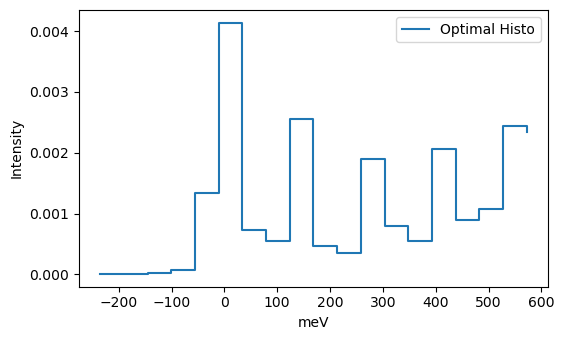

Calculating KDE
   - linear scale
nx 19
slice size 4.48


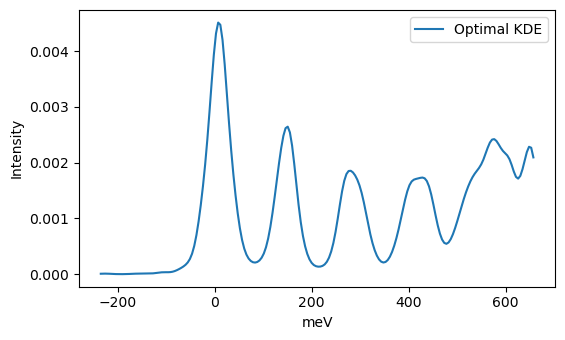

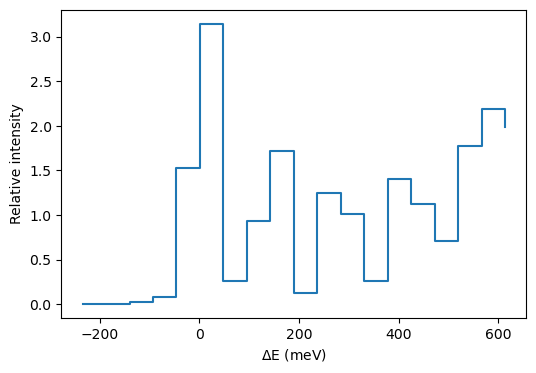

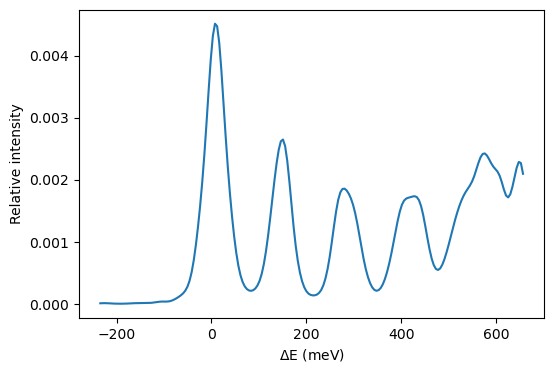

In [124]:
cpo = ema1.subsample(5000, randomize=False)

print("Data size is", cpo.data.size)

cpo.plot_histogram(loglog=False,log=False, xlabel='meV')
cpo.plot_kde(loglog=False,log=False, xlabel='meV', method='fdr')

# Manually replot and save figure for a paper
bn=cpo.optimal_n_bins()
hst = np.histogram(cpo.data, bins=bn, weights=cpo.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_histo.png', dpi=600, bbox_inches='tight')
plt.show()

fig,ax=plt.subplots()
plt.plot(cpo.kdex, cpo.kdey)
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_kde.png', dpi=600, bbox_inches='tight')
plt.show()

In [125]:
# Build MCMC Models with API

def simplex_weights(Qraw: np.ndarray) -> np.ndarray:
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    if -100.0 < elmu < 100.0 and \
        100.0 < mu1  < 200.0 and \
        200.0 < mu2  < 350.0 and \
        350.0 < mu3  < 450.0 and \
        500.0 < mu4  < 620.0 and \
        600.0 < mubg1< 700.0 and \
        0.0   < mubg2< 200.0 and \
        10.0 < elsigma < 100.0 and \
        10.0 < s1 < 100.0 and \
        10.0 < s2 < 100.0 and \
        10.0 < s3 < 100.0 and \
        10.0 < s4 < 100.0 and \
        100.0 < sbg1 < 250.0 and \
        10.0  < sbg2 < 250.0 and \
        0.1 < m1 < 1.0 and\
        0.1 < m2 < 1.0 and\
        0.1 < m3 < 1.0 and\
        0.1 < m4 < 1.0 and\
        0.1 < mbg1 < 1.0 and\
        0.1 < mbg2 < 1.0 and\
        m1 + m2 + m3 + m4 + mbg1 + mbg2 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin


    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(xx, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(xx, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(xx, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(xx, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(xx, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(xx, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(xx, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)

    
    sol = (el + l1 + l2 + l3 + l4 + bg1 + bg2)**use_weights
    
    return sol



def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):

    raiseError = False
    result = 0.0

    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf

    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))
    


    el = mvals[0] * norm.pdf(data, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)
    l1 = mvals[1] * norm.pdf(data, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(data, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(data, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(data, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(data, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(data, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)


    # Guard against zero values in each term
    minval = 1.0E-300

    msk = el < minval
    el[msk] = minval

    msk = l1 < minval
    l1[msk] = minval

    msk = l2 < minval
    l2[msk] = minval

    msk = l3 < minval
    l3[msk] = minval

    msk = l4 < minval
    l4[msk] = minval

    msk = bg1 < minval
    bg1[msk] = minval

    msk = bg2 < minval
    bg2[msk] = minval

    
 #   try:
    lel = np.log(el)
    ll1 = np.log(l1)
    ll2 = np.log(l2)
    ll3 = np.log(l3)
    ll4 = np.log(l4)
    lbg1 = np.log(bg1)
    lbg2 = np.log(bg2)

    lt1 = np.logaddexp(lel, ll1)
    lt2 = np.logaddexp(lt1, ll2)
    lt3 = np.logaddexp(lt2, ll3)
    lt4 = np.logaddexp(lt3, ll4)
    lt5 = np.logaddexp(lt4, lbg1)
    lt6 = np.logaddexp(lt5, lbg2)

    lll = np.sum(lt6 * use_weights)
    
    result = lp + lll

    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        verbose=True
                    
    if verbose==True:
        print("lp", lp)
        print("lll", lll)
        print("l1", l1)
        print("l2", l2)
        print("l3", l3)
        print("l4", l4)
        print("bg1", bg1)
        print("bg2", bg2)
        print("")
        print("m0", mvals[0])
        print("m1", mvals[1])
        print("m2", mvals[2])
        print("m3", mvals[3])
        print("m4", mvals[4])
        print("m5", mvals[5])
        print("m6", mvals[6])

    return result

    
#   except RuntimeWarning as e:
#        print("Runtime warning at", theta)
#        print(e)
#        raise
    


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

# Seed MCMC search manually
# ema1.make_lse_params(
#    amplitude=dict(value=1.0, min=0.0),\
#    elmu = dict(value=10.0, min=-100.0, max=100.0),\
#    mu1 = dict(value=150.0, min=100.0, max=200.0),\
#    mu2 = dict(value=280.0, min=200.0, max=350.0),\
#    mu3 = dict(value=420.0, min=350.0, max=450.0),\
#    mu4 = dict(value=560.0, min=500.0, max=620.0),\
#    mubg1=dict(value=620.0, min=600.0, max=700.0),\
#    mubg2=dict(value=140.0, min=0.0, max=200.0),\

#    elsigma = dict(value=20.0, min=10.0, max=100.0),\
#    s1 = dict(value=30.0, min=10.0, max=100.0),\
#    s2 = dict(value=30.0, min=10.0, max=100.0),\
#    s3 = dict(value=30.0, min=10.0, max=100.0),\
#    s4 = dict(value=30.0, min=10.0, max=100.0),\
#    sbg1=dict(value=100.0, min=100.0, max=250.0),\
#    sbg2=dict(value=20.0, min=10.0, max=250.0),\
#    m1=dict(value=0.3, min=0.0, max = 1.0),\
#    m2=dict(value=0.2, min=0.0, max = 1.0),\
#    m3=dict(value=0.15, min=0.0, max = 1.0),\
#    m4=dict(value=0.1, min=0.0, max = 1.0),\
#    mbg1=dict(value=0.1, min=0.0, max=1.0),\
#    mbg2=dict(value=0.1, min=0.0, max=1.0)
#)

same_as_least_squares = np.array([10.0, 150.0, 280.0, 420.0, 560.0,\
                                 620.0, 140.0, 20.0, 30.0, 30.0,\
                                 30.0, 30.0, 100.0, 20.0,\
                                 0.3, 0.2, 0.15, 0.1, 0.1, 0.1])

#cpo.theta_seed = np.array([7.83319976e+00, 1.45695047e+02, 2.81254328e+02,\
# 4.14035526e+02, 5.52327378e+02, 6.99999691e+02, 2.30190791e-02,\
# 1.86422670e+01, 1.99165093e+01, 2.21066916e+01, 2.75136714e+01,\
# 2.79613790e+01, 1.16801601e+02, 4.02817313e+01, 1.90420268e-01,\
# 1.40207127e-01, 1.18191129e-01, 1.18351136e-01, 7.89817013e-02,\
# 2.74781599e-01])

nan_location = np.array([9.99999112e+00, 1.49999991e+02, 2.80000003e+02, 4.20000001e+02,\
 5.60000002e+02, 6.20000016e+02, 1.39999999e+02, 2.00000157e+01,\
 2.99999882e+01, 3.00000001e+01, 3.00000015e+01, 3.00000010e+01,\
 1.00000001e+02, 2.00000099e+01, 2.99987259e-01, 2.00008231e-01,\
 1.50005576e-01, 1.00000433e-01, 1.00000804e-01, 1.00002444e-01])

cpo.theta_seed = same_as_least_squares

# Seed MCMC search with LSE fit
#cpo.lse_fit()
#cpo.theta_seed = detailed_fit_params # <- this takes parameters from the detailed fit done earlier
#cpo.theta_seed = cpo.theta_seed[1:]

#log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False)
#test=log_likelihood_function(nan_location, ema1.data, np.amin(ema1.data), np.amax(ema1.data), ema1.weights, log_prior_function, verbose=True)

cpo.nwalkers=32 # need to increase this to improve sampling stats quality 
# (see plots of MCMC_parameter_distribution later) 

cpo.MCMC_fit(nburn=150, niter=150) # fixed number of iterations
#cpo.MCMC_fit(niter=5000, convergence="Gelman-Rubin") # gelman-rubin method to check for convergence


MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:05<00:00, 28.00it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:05<00:00, 29.50it/s]

MCMC sampling complete.


(150, 41, 20)
(150, 41, 20)


True

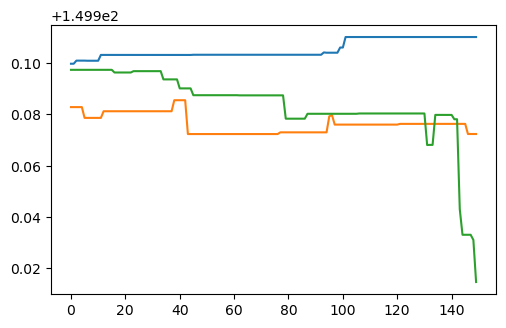

In [126]:
chz = cpo.sampler.get_chain()
nwk = cpo.nwalkers
ndm = cpo.ndim

rlen = chz.shape[0]

print(chz.shape)

burned = chz[-1000::]
#=np.delete(chz, np.s_[rlen-42:rlen], axis=0)
print(burned.shape)
ch1 = burned[:,1,1]
ch2 = burned[:,2,1]
ch3 = burned[:,3,1]
fig,ax=plt.subplots()
ax.plot(ch1)
ax.plot(ch2)
ax.plot(ch3)

cpo.self_check()

In [127]:
# The standard deviation is the square root of the variance.
# Therefore, the variance should be the standard deviation squared.

chz = cpo.sampler.get_chain()
nw = float(cpo.nwalkers)
nd = float(cpo.ndim)
ns = float(chz.shape[0])

print(chz.shape)

mns = np.mean(chz, axis=0)
print("mean shape", mns.shape)
gmn = np.mean(mns, axis=0)
print("gmn  shape", gmn.shape)


wch_variance = 1.0 / (ns - 1.0) * np.sum( (chz - mns)**2.0, axis=0)
print("wchv shape", wch_variance.shape)
wch_var_alt = np.std(chz, axis=0)**2.0
print("w alt shape", wch_var_alt.shape)


bch_variance = ns/(nw - 1.0) * np.sum( (mns - gmn)**2.0, axis=0)
print("bchv shape", bch_variance.shape)

print(bch_variance)

bch_alt_variance = np.std(mns, axis=0)**2.0
print("b alt shape", bch_alt_variance.shape)
print(bch_alt_variance)


ww = (1.0 / nw) * np.sum(wch_variance, axis=0)

wwalt = np.mean(wch_var_alt, axis=0)

print("ww shape", ww.shape)
print("wwalt sh", wwalt.shape)

print("ww", ww)
print("wwalt", wwalt)

t1 = (ns-1.0)*ww / ns
t2 = bch_variance / ns

t1alt = (ns-1.0) * wwalt / ns
t2alt = (bch_alt_variance)

print("t1 shape", t1.shape)
print("t2 shape", t2.shape)

grstat = (t1 + t2) / ww
print(grstat)

gralt = (t1alt + t2alt) / wwalt
print(gralt)


(150, 41, 20)
mean shape (41, 20)
gmn  shape (20,)
wchv shape (41, 20)
w alt shape (41, 20)
bchv shape (20,)
[0.21295154 2.16164729 0.63460098 0.11122216 0.28335132 0.67389537
 0.28405919 0.09493823 1.47084747 0.90358247 0.40230271 0.32367889
 0.27863532 0.38967259 0.40518924 0.20469009 0.32515612 0.04949569
 0.27414199 0.05598836]
b alt shape (20,)
[0.00138505 0.01405949 0.00412749 0.0007234  0.00184294 0.00438306
 0.00184754 0.00061748 0.00956649 0.00587696 0.0026166  0.00210523
 0.00181226 0.00253446 0.00263538 0.00133132 0.00211484 0.00032192
 0.00178304 0.00036415]
ww shape (20,)
wwalt sh (20,)
ww [8.69195344e-04 4.05493554e-03 1.19610507e-03 2.15598695e-04
 3.29722489e-04 1.17966117e-03 4.16417609e-04 2.84961044e-04
 1.21980054e-03 2.77310430e-03 1.38722197e-03 3.54102755e-04
 6.63531490e-04 1.40762475e-03 7.33695638e-04 2.27728055e-04
 2.71858235e-04 4.70796199e-05 2.78747762e-04 6.07654060e-05]
wwalt [8.63400709e-04 4.02790264e-03 1.18813103e-03 2.14161370e-04
 3.27524339e-04 1

In [128]:
  def gsdev(mcmcObject, burn=50) -> np.ndarray :

        # Something is a bit wrong with this.
        # The statistic is starting out at a value of 2
        # in the ARCS test notebook and gently increasing
        # It should not be behaving in this way, there is obviously
        # a mistake in the maths below...

        chains = mcmcObject.sampler.get_chain(discard=burn)
            
        nwk = mcmcObject.nwalkers # "J"
        ndm = mcmcObject.ndim
        nsamps = chains.shape[0] #"L"

        chain_mean = np.mean(chains, axis=0)        
        grand_mean = np.mean(chain_mean, axis=0)

        within_chain_variance = 1.0 / (nsamps - 1.0) * np.sum( (chains - grand_mean)**2.0, axis=0)
        between_chain_variance = nsamps/(nwk - 1.0) * np.sum( (chain_mean - grand_mean)**2.0, axis=0)
        
        ww = (1.0 / nwk) * np.sum(within_chain_variance, axis=0)
        
        t1 = (nsamps-1.0)*ww / nsamps
        t2 = between_chain_variance / nsamps
        
        grstat = (t1 + t2) / ww
        
        return grstat

gs0 = gsdev(cpo, burn=0)
gs10 = gsdev(cpo, burn=10)
gs50 = gsdev(cpo, burn=50)
gs100= gsdev(cpo, burn=100)
gs150= gsdev(cpo, burn=150)

print(gs0)
print(gs10)
print(gs50)
print(gs100)
print(gs150)

[1.62052609 1.78476333 1.78392239 1.7789255  1.85785773 1.79671776
 1.82524512 1.69146784 1.89703882 1.68656987 1.66027205 1.86573837
 1.73995762 1.64949852 1.79092799 1.86362502 1.89621059 1.88235228
 1.87464096 1.86672949]
[1.64521965 1.8276919  1.82149069 1.80795297 1.89772385 1.82797971
 1.861785   1.70989937 1.93328274 1.72289048 1.67675303 1.89017371
 1.77621726 1.66911102 1.81246497 1.8694839  1.90477804 1.89454301
 1.88953661 1.88001272]
[1.77276058 1.90769089 1.89497818 1.87577028 1.95843521 1.89445197
 1.92757553 1.78260226 1.98075379 1.84378299 1.76907024 1.93641672
 1.85653075 1.78166221 1.89183189 1.89731026 1.93423262 1.93724359
 1.9435172  1.92144946]
[1.93559721 1.9500975  1.94815515 1.96834023 1.97281722 1.94344142
 1.95799291 1.96268091 1.97816249 1.94035833 1.90042899 1.95852562
 1.97086913 1.91297293 1.95153291 1.94475782 1.94885152 1.97050536
 1.96612014 1.95175251]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2058/62179585.py:23: RuntimeWarning: invalid value encountered in divide
  t1 = (nsamps-1.0)*ww / nsamps


Calculating KDE
   - linear scale
nx 19
slice size 4.48


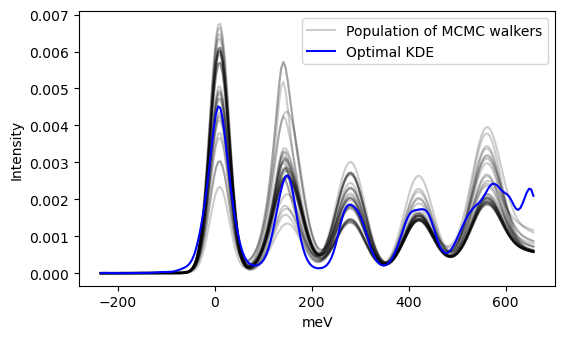

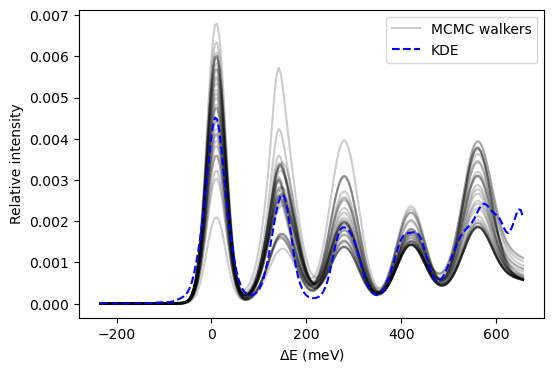

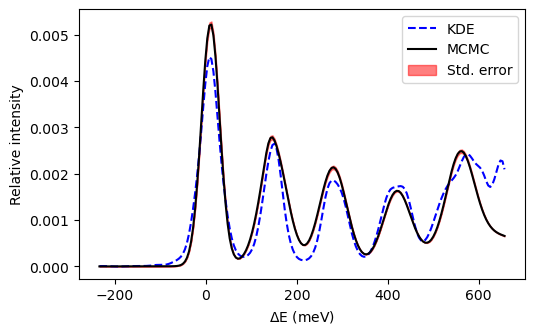

In [129]:
#cpo.plot_LSE_fit(loglog=False, log=False, xlabel='meV')
#cpo.plot_MCMC_fit(method="histo", loglog=False, log=False, xlabel='meV', save="arcs_mcmc_fit.png")

cpo.self_check()

cpo.plot_MCMC_fit(method='kde', loglog=False, log=False, xlabel='meV')
#cpo.plot_MCMC_fit(method='histo', loglog=False, log=False, xlabel='meV')

# Repeat plot manually for paper output

flt = cpo.sampler.get_chain(discard=20, thin=15, flat=True)
inds  = np.random.choice(len(flt), size=30, replace=False)
pt_sum = np.sum(cpo.kdey)

fig,ax=plt.subplots()

for ind in inds:
    smp = flt[ind]
    yfit = cpo.pmf(smp, cpo.kdex, cpo.xmin, cpo.xmax, None)
    ysum = np.sum(yfit)
    scale = pt_sum / ysum
    yfit = yfit * scale

    if ind == inds[0]:
        ax.plot(cpo.kdex, yfit, color='black', alpha=0.2, label='MCMC walkers')
    else:
        ax.plot(cpo.kdex, yfit, color='black', alpha=0.2)

plt.plot(cpo.kdex, cpo.kdey, ls='--', color='blue', label='KDE')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
#plt.xlim([410, 435])
#plt.ylim([0.0014, 0.00195])
plt.legend()
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_kde_fit.png', dpi=600, bbox_inches='tight')
plt.show()

# Plot showing the average of the PDFs over all walkers?
inds = np.arange(len(flt))

yfit = np.zeros((len(inds),cpo.kdex.size))

for ind in inds:
    smp = flt[ind]
    yfit[ind] = cpo.pmf(smp, cpo.kdex, cpo.xmin, cpo.xmax, None)

ymean = np.mean(yfit, axis=0)
ystd = np.std(yfit, axis=0)
ystd = ystd / np.sqrt(len(inds))

                
ysum = np.sum(ymean)
scale = pt_sum / ysum
ymean = ymean * scale
ystd = ystd * scale

plt.plot(cpo.kdex, cpo.kdey, ls='--', color='blue', label='KDE')
plt.plot(cpo.kdex, ymean, color='black', label='MCMC')
plt.fill_between(cpo.kdex, ymean-ystd, ymean+ystd, color='red', alpha=0.5, label='Std. error')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
#plt.xlim([410, 435])
#plt.ylim([0.0014, 0.00195])
plt.legend()
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_kde_fit_mean.png', dpi=600, bbox_inches='tight')
plt.show()

stdd 0.04741783802086897
stdd 0.13448939442940958
stdd 0.07290827856023234
stdd 0.03061956093229093
stdd 0.04658819342725721
stdd 0.07453090695537665
stdd 0.047551876166575587
stdd 0.030009093643152435
stdd 0.10381789907126086
stdd 0.09290627577245769
stdd 0.0632026647036496
stdd 0.04956783853917234
stdd 0.04971287772279639
stdd 0.06271121485016629
stdd 0.05800156466670389
stdd 0.0394655230469122
stdd 0.04883525807501795
stdd 0.01920127408409646
stdd 0.04538641619294525
stdd 0.020603694085482
149.9985637304222 +/- 0.001714946120843636 using method mean


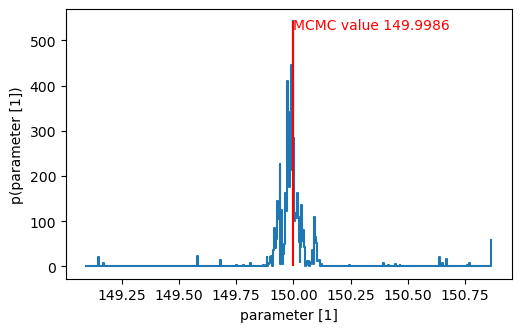

fwhm 2.460955590115777
fwhm 1.9023064687168585
fwhm 3.026942795466809
fwhm 2.820378151260506
fwhm 2.0799355495251
fwhm 1.728825550838895
fwhm 3.440422801376414
fwhm 1.3907234858865536
fwhm 2.9688995215310996
fwhm 1.946158977599893
fwhm 6.304858299595139
fwhm 2.7073347364609504
fwhm 1.2142857142857135
fwhm 1.592933451279265
fwhm 3.7830358604879635
fwhm 1.6468926374230186
fwhm 2.208710935579555
fwhm 0.9070796460176993
fwhm 1.9867177160143683
fwhm 1.015037593984962
149.9981571980141 +/- 0.014280409441419235 using method peak


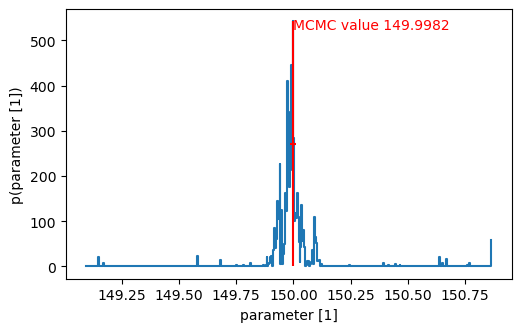

In [130]:
lookat=1
#cpo.plot_MCMC_parameter_distribution(lookat, compare=True)
cpo.plot_MCMC_parameter_distribution(lookat, compare=False, method='mean', savename='arcsFigs/arcs_parameter_mean.png')
cpo.plot_MCMC_parameter_distribution(lookat, compare=False, method='peak', savename='arcsFigs/arcs_parameter_peak.png')


In [131]:
print("PEAK METHOD:")
mcpparams, mcperr = cpo.get_MCMC_parameters(method='peak')
print(mcpparams)
print(mcperr)

print()
print("MEAN METHOD:")
mcparams, mcerr = cpo.get_MCMC_parameters(method='mean')
print(mcparams)
print(mcerr)

print()
print("LSE on full data set")
lsparams = ema1.get_lse_param_values()


lserrors = ema1.get_lse_param_errors()
print(lsparams)
print(lserrors)

import pandas

pn = ema1.get_lse_param_names()
pn = pn[1:]

df = pandas.DataFrame({"PARAMETER": pn, "LSE": lsparams[1:], "LSE_ERR": lserrors[1:], "BAYES": mcparams, "BAYES_ERR": mcerr, "BAYES-PEAK": mcpparams, "BAYES-PEAK-ERR": mcperr})
print(df)

PEAK METHOD:
fwhm 2.460955590115777
fwhm 1.9023064687168585
fwhm 3.026942795466809
fwhm 2.820378151260506
fwhm 2.0799355495251
fwhm 1.728825550838895
fwhm 3.440422801376414
fwhm 1.3907234858865536
fwhm 2.9688995215310996
fwhm 1.946158977599893
fwhm 6.304858299595139
fwhm 2.7073347364609504
fwhm 1.2142857142857135
fwhm 1.592933451279265
fwhm 3.7830358604879635
fwhm 1.6468926374230186
fwhm 2.208710935579555
fwhm 0.9070796460176993
fwhm 1.9867177160143683
fwhm 1.015037593984962
[9.99756496e+00 1.49998157e+02 2.79997260e+02 4.19999115e+02
 5.59988056e+02 6.19996632e+02 1.39998399e+02 1.99991463e+01
 2.99935759e+01 2.99993277e+01 2.99948045e+01 2.99978498e+01
 1.00000002e+02 1.99986574e+01 2.97424816e-01 1.98409007e-01
 1.00004090e-01 1.00000170e-01 1.00000911e-01 1.00000851e-01]
[0.01847413 0.01428041 0.02272293 0.02117227 0.01561385 0.01297811
 0.02582688 0.01044001 0.02228721 0.01460961 0.04732989 0.02032367
 0.00911551 0.01195798 0.02839884 0.01236305 0.01658055 0.00680935
 0.01491408 0

AttributeError: 'NoneType' object has no attribute 'best_values'

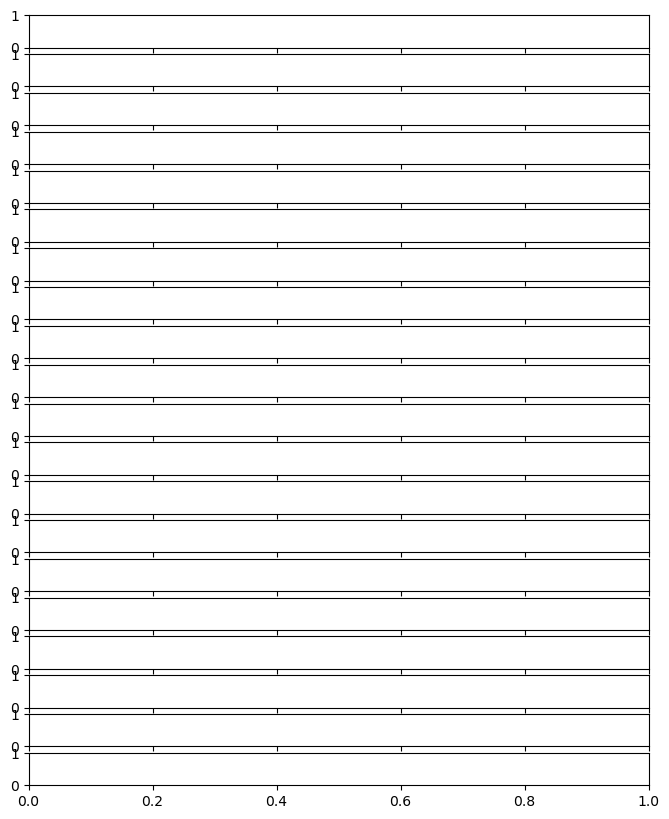

In [12]:
cpo.plot_MCMC_convergences()

## Event-dependent convergence study

In [132]:
print(same_as_least_squares)
print(lse_starting_parameters)

[1.0e+01 1.5e+02 2.8e+02 4.2e+02 5.6e+02 6.2e+02 1.4e+02 2.0e+01 3.0e+01
 3.0e+01 3.0e+01 3.0e+01 1.0e+02 2.0e+01 3.0e-01 2.0e-01 1.5e-01 1.0e-01
 1.0e-01 1.0e-01]
Parameters([('amplitude', <Parameter 'amplitude', value=1.0, bounds=[0.0:inf]>), ('elmu', <Parameter 'elmu', value=10.0, bounds=[-100.0:100.0]>), ('mu1', <Parameter 'mu1', value=150.0, bounds=[100.0:200.0]>), ('mu2', <Parameter 'mu2', value=280.0, bounds=[200.0:350.0]>), ('mu3', <Parameter 'mu3', value=420.0, bounds=[350.0:450.0]>), ('mu4', <Parameter 'mu4', value=560.0, bounds=[500.0:620.0]>), ('mubg1', <Parameter 'mubg1', value=620.0, bounds=[600.0:700.0]>), ('mubg2', <Parameter 'mubg2', value=140.0, bounds=[0.0:200.0]>), ('elsigma', <Parameter 'elsigma', value=20.0, bounds=[10.0:100.0]>), ('s1', <Parameter 's1', value=30.0, bounds=[10.0:100.0]>), ('s2', <Parameter 's2', value=30.0, bounds=[10.0:100.0]>), ('s3', <Parameter 's3', value=30.0, bounds=[10.0:100.0]>), ('s4', <Parameter 's4', value=30.0, bounds=[10.0:100.0]>), (

In [133]:
# The original version of this code in the first draft of the paper erroneously used the ".subsample" function.
# Each time it's called, subsample takes a random set of data.
#
# What we actually need to do is take the first nn data points to simulate having taken different measurement collection times, so that
# the first points in the data set are always the same, and the last points are the new ones.
# This should have the effect of removing huge fluctuation errors in the convergence curves.
# I left in the subsample as a comment, and put in the correct code directly below it.


assumed_param_values = np.copy(mcparams)

RANDOM_SEED = 1
np.random.seed(seed=RANDOM_SEED)

maxsiz = np.log10(evs.size)
print(evs.size)
print(maxsiz)
evreps=10
n_evs = np.logspace(2, maxsiz, evreps).astype(int)
print(n_evs)
n_evs[-1]=evs.size
print(n_evs)

lse_results = np.zeros((evreps, mcparams.size+1))
lse_errors  = np.zeros((evreps, mcparams.size+1))
mcmc_results = np.zeros((evreps, mcparams.size))
mcmc_errors = np.zeros((evreps, mcparams.size))


lsMinEvents = 10000
mcmcMinEvents = 10
lsMaxEvents = 10000000
mcmcMaxEvents = 90000


rep = 0

for nn in n_evs:
    print("Rep", rep+1, "/", evreps, "|", nn, "/", evs.size)
    print("Subsampling...")
    sse = ema1.subsample(nn, randomize=False)
    # Manually subsample the first nn points instead of randomly subsampling them

    sse.lpf = log_prior_function
    sse.pmf = probability_mass_function
    sse.llf = log_likelihood_function


    if nn >= lsMinEvents and nn <= lsMaxEvents:
        print("Least Squares Analysis...")
        sse.least_squares_parameters = copy.deepcopy(lse_starting_parameters)
        sse.calculate_histogram()
        sse.lse_fit()
        #sse.plot_LSE_fit(loglog=False, log=False, xlabel='meV')


        lse_results[rep,:] = sse.get_lse_param_values()
        lse_errors[rep,:] = sse.get_lse_param_errors()
    else:
        print("Skipping Least Squares Analysis (too few events for stable fit)")

    if nn >= mcmcMinEvents and nn <= mcmcMaxEvents:
        print("MCMC Analysis...")
        sse.nwalkers=128 # need to increase this to improve sampling stats quality 
        # (on plots of MCMC_parameter_distribution) 

        sse.theta_seed = same_as_least_squares
        sse.MCMC_fit(nburn=150, niter=150)

        mcmc_results[rep,:], mcmc_errors[rep,:] = sse.get_MCMC_parameters(method='mean')
    else:
        print("Skipping MCMC Analysis (too many events to run on a laptop in sensible time)")

    rep = rep + 1

print("Convergence loop complete.")

2623437
6.418870639382126
[    100     309     959    2971    9203   28505   88290  273463  847003
 2623436]
[    100     309     959    2971    9203   28505   88290  273463  847003
 2623437]
Rep 1 / 10 | 100 / 2623437
Subsampling...
Subsampling in order.
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


  0%|                                                   | 0/150 [00:00<?, ?it/s]/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 24.12it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:05<00:00, 25.81it/s]


MCMC sampling complete.
stdd 0.10701216705517519
stdd 0.16388233689590595
stdd 0.12584925648334397
stdd 0.10792787321502124
stdd 0.1463988363149638
stdd 0.13834249033170262
stdd 0.10658705398728095
stdd 0.11572506269579017
stdd 0.18989264819670584
stdd 0.10176181967171588
stdd 0.17554572252497438
stdd 0.13706020416475923
stdd 0.07598746365672311
stdd 0.15451490133327025
stdd 0.08038511873846975
stdd 0.04407182082586785
stdd 0.03579099516105819
stdd 0.03719294837409066
stdd 0.026297643221236018
stdd 0.01953818423416457
Rep 2 / 10 | 309 / 2623437
Subsampling...
Subsampling in order.
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 23.54it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 24.64it/s]


MCMC sampling complete.
stdd 0.08810822759069924
stdd 0.09888885675315831
stdd 0.08691966443349881
stdd 0.09060701797165152
stdd 0.07642591872839902
stdd 0.08815926152673656
stdd 0.06537699163138515
stdd 0.07602686153809868
stdd 0.1255159690513198
stdd 0.07222751843148369
stdd 0.08572327059312378
stdd 0.06539236228747848
stdd 0.03787092166703888
stdd 0.10055148779034623
stdd 0.06542569956424744
stdd 0.04786136343537647
stdd 0.04114185011610437
stdd 0.023540081379938918
stdd 0.03108424915975195
stdd 0.04639344013915925
Rep 3 / 10 | 959 / 2623437
Subsampling...
Subsampling in order.
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:07<00:00, 18.99it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:07<00:00, 19.46it/s]


MCMC sampling complete.
stdd 0.055636834036361056
stdd 0.07780175307006994
stdd 0.1363719732412183
stdd 0.08593922615997511
stdd 0.10787856313388929
stdd 0.06131962857873271
stdd 0.07332537968687064
stdd 0.08078659894827377
stdd 0.13534037992335318
stdd 0.06671199175924306
stdd 0.07233646538736282
stdd 0.10109628428741399
stdd 0.05980680223276854
stdd 0.11001078709547324
stdd 0.08192215156338735
stdd 0.053632149752898726
stdd 0.03741532981183489
stdd 0.02799767787552917
stdd 0.023070052299108027
stdd 0.032650092019371475
Rep 4 / 10 | 2971 / 2623437
Subsampling...
Subsampling in order.
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.29it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.93it/s]


MCMC sampling complete.
stdd 0.13962346998156713
stdd 0.08657649697166497
stdd 0.0724841281901004
stdd 0.04862223482341527
stdd 0.0848381593091715
stdd 0.12093568921826595
stdd 0.10444194852455602
stdd 0.10494379787143655
stdd 0.06264690066624277
stdd 0.09302836645550511
stdd 0.07840474491112431
stdd 0.09636569672689624
stdd 0.03576472584397875
stdd 0.09167437693860392
stdd 0.08314941120781397
stdd 0.04693743874847695
stdd 0.0631451730054964
stdd 0.03628167366829764
stdd 0.02586311186030245
stdd 0.026866865203430762
Rep 5 / 10 | 9203 / 2623437
Subsampling...
Subsampling in order.
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:26<00:00,  5.65it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:24<00:00,  6.05it/s]


MCMC sampling complete.
stdd 0.11381809073312799
stdd 0.12219725244982643
stdd 0.10066858745428084
stdd 0.09266568596713637
stdd 0.13262153691689457
stdd 0.09203409902138576
stdd 0.15118703619338705
stdd 0.08674428305451601
stdd 0.1168884117114985
stdd 0.11850342549930727
stdd 0.13026163296492216
stdd 0.1109690405506191
stdd 0.03777810031762644
stdd 0.07792013715635808
stdd 0.06780404968657033
stdd 0.050777861458961994
stdd 0.04365321613910965
stdd 0.044754981613849595
stdd 0.015548281777949148
stdd 0.0419749437838508
Rep 6 / 10 | 28505 / 2623437
Subsampling...
Subsampling in order.
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [01:12<00:00,  2.06it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [01:10<00:00,  2.13it/s]


MCMC sampling complete.
stdd 0.1208577693756811
stdd 0.07223070105496163
stdd 0.13587452863079788
stdd 0.15757356930870334
stdd 0.15337241694064316
stdd 0.11659277515117904
stdd 0.18308846872120235
stdd 0.1423377661321175
stdd 0.17412995960780775
stdd 0.22786446568194824
stdd 0.15996601293692445
stdd 0.15229352597212056
stdd 0.0489508088133988
stdd 0.11003966350354291
stdd 0.0667470341887579
stdd 0.04965000474546443
stdd 0.0368887796537354
stdd 0.0288199450630336
stdd 0.023674319996238556
stdd 0.06603549199525172
Rep 7 / 10 | 88290 / 2623437
Subsampling...
Subsampling in order.
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [03:34<00:00,  1.43s/it]


Sampling:


100%|█████████████████████████████████████████| 150/150 [03:45<00:00,  1.50s/it]


MCMC sampling complete.
stdd 0.7443495402220552
stdd 0.586253647420092
stdd 1.2744555720527388
stdd 0.5649453341545004
stdd 0.43282149346891235
stdd 0.70193699742976
stdd 0.3366805711523546
stdd 0.6701749067219221
stdd 0.42898177559444
stdd 0.5204139696887792
stdd 0.3903917192932338
stdd 0.3693529594307037
stdd 0.28359431807995406
stdd 0.36091977243344325
stdd 0.040543830353592374
stdd 0.03672680185373401
stdd 0.026755270724982107
stdd 0.03192711746859815
stdd 0.03381475683005392
stdd 0.03352903596632007
Rep 8 / 10 | 273463 / 2623437
Subsampling...
Subsampling in order.
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 9 / 10 | 847003 / 2623437
Subsampling...
Subsampling in order.
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 10 / 10 | 2623437 / 2623437
Subsampling...
Subsample will return a direct copy of the data instead.
Least Squares Analysis...
Skipping MCMC Analys

In [134]:
def p_conv_plot(item, param_name='', Bayes=True, LSE=True, savename='', correct=np.inf, ylims=[np.inf, np.inf]):

    # Least squares parameters
    pnams = sse.get_lse_param_names()
    pnam = pnams[item+1]
    
    lsnevs = n_evs
    lsvalues = lse_results[:,item+1]
    lserrs = lse_errors[:,item+1]

    lsmask = lsvalues != 0.0
    lsnevs = lsnevs[lsmask]
    lsvalues = lsvalues[lsmask]
    lserrs = lserrs[lsmask]
    
    lsbtop = lsvalues+lserrs
    lsbbot = lsvalues-lserrs
    lswtop = np.amax(lsvalues)
    lswbot = np.amin(lsvalues)

    # Bayesian parameters
    mcnevs = n_evs
    mcvalues = mcmc_results[:,item]
    mcerrs = mcmc_errors[:,item]

    mcmask = mcvalues != 0.0
    mcvalues = mcvalues[mcmask]
    mcerrs = mcerrs[mcmask]
    mcnevs = mcnevs[mcmask]
    
    
    mcbtop = mcvalues+mcerrs
    mcbbot = mcvalues-mcerrs
    mcwtop = np.amax(mcvalues)
    mcwbot = np.amin(mcvalues)
    
    
    wtop = np.amax([lswtop, mcwtop])
    wbot = np.amin([lswbot, mcwbot])

    wspan = wtop - wbot
    wpad = wspan * 0.1
    wtop = wtop + np.abs(wpad)
    wbot = wbot - np.abs(wpad)

        
    fig, ax = plt.subplots()
    if LSE:
        ax.plot(lsnevs, lsvalues, color='blue', label='LSE')
        ax.fill_between(lsnevs, lsbbot, lsbtop, color='blue', alpha=0.15, label='LSE std. err')
        ax.set_ylim([wbot, wtop])
        ax.set_xlabel("# events")
        ax.set_ylabel(pnam + "Value")
        if param_name != '':
            ax.set_ylabel(param_name)

    if Bayes:
        ax.plot(mcnevs, mcvalues, color='red', label='Bayes')
        ax.fill_between(mcnevs, mcbbot, mcbtop, color='red', alpha=0.15, label='Bayes std. err')

    if np.isfinite(correct):
        xmin=np.amin(mcnevs)
        xmax=np.amax(lsnevs)
        plt.hlines(correct, xmin, xmax, label='Visual estimate', ls='--', color='orange')


    if np.isfinite(ylims).all():
        plt.ylim(ylims)
    
    
    plt.xscale('log')
    plt.yscale('linear')
    ax.legend()

        

    if savename != '':
        plt.savefig(savename, dpi=600, bbox_inches='tight')
        plt.show()
    
    #print(sse.get_lse_param_names())

    

### Elastic Line Parameters

What are the correct values?  lets inspect the kde of the full data set.

Calculating KDE
   - linear scale
nx 224
slice size 0.5880000000000001


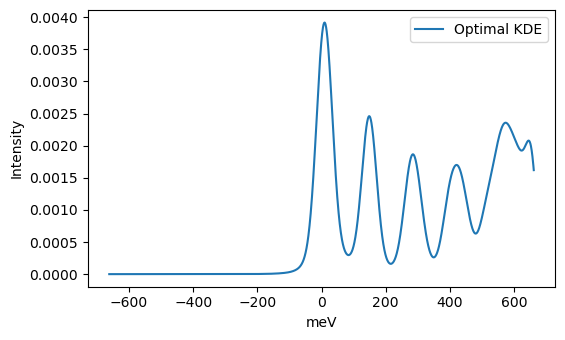

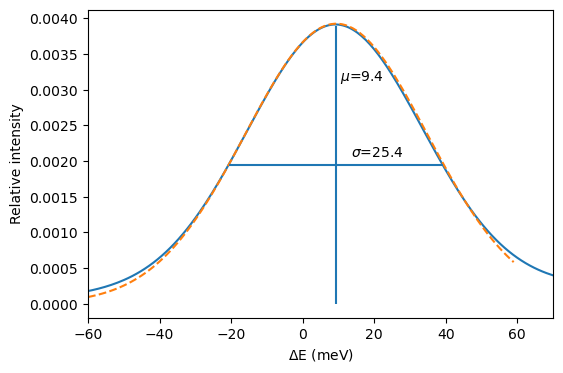

In [135]:
ema1.plot_kde(loglog=False,log=False, xlabel='meV', method='silverman')

mu=9.4
sig=25.4
norm=4.0
ht=0.0039

px=np.arange(-60,60,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([-60,70])
plt.savefig('arcsFigs/arcs_fulldata_kde_elastic.png', dpi=600, bbox_inches='tight')
plt.show()

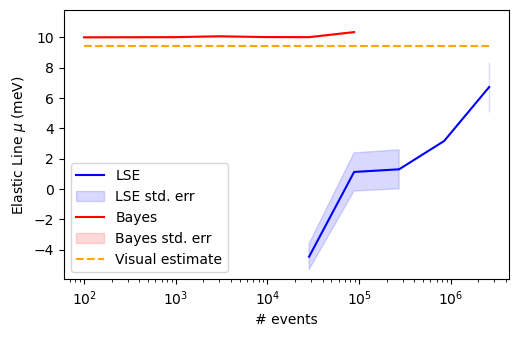

In [136]:
parameter_no = 0
p_conv_plot(parameter_no, param_name='Elastic Line $\mu$ (meV)', savename='arcsFigs/arcs_elastic_mu.png', correct=9.4)
#p_conv_plot(parameter_no, LSE=False)

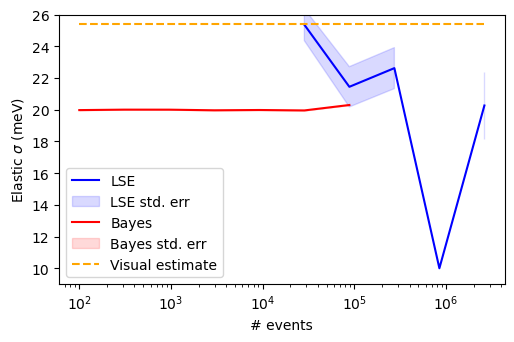

In [137]:
parameter_no = 7
p_conv_plot(parameter_no, param_name='Elastic $\sigma$ (meV)', savename='arcsFigs/arcs_elastic_sigma.png', correct=25.4, ylims=[9, 26])
#p_conv_plot(parameter_no, LSE=False)

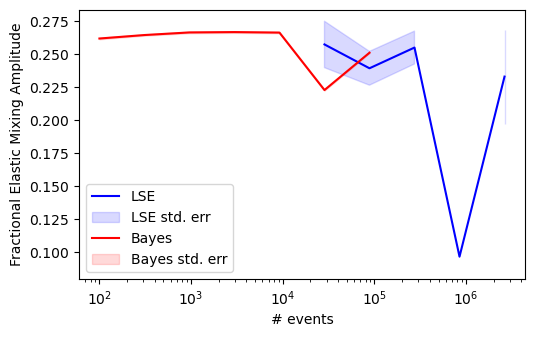

In [138]:
parameter_no = 14
p_conv_plot(parameter_no, param_name='Fractional Elastic Mixing Amplitude', savename='arcsFigs/arcs_elastic_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### First Excitation Line Parameters

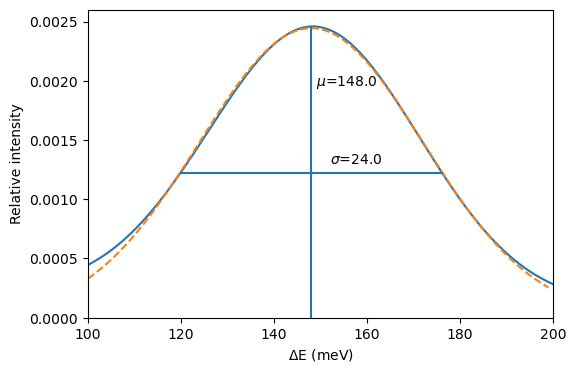

In [139]:
mu=148.0
sig=24.0
norm=6.8
ht=0.00245

px=np.arange(100,200,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([100,200])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex1.png', dpi=600, bbox_inches='tight')
plt.show()

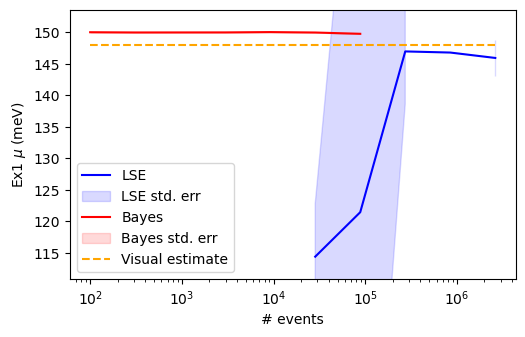

In [140]:
parameter_no = 1
p_conv_plot(parameter_no, param_name='Ex1 $\mu$ (meV)', savename='arcsFigs/arcs_ex1_mu.png', correct=148.0)
#p_conv_plot(parameter_no, LSE=False)

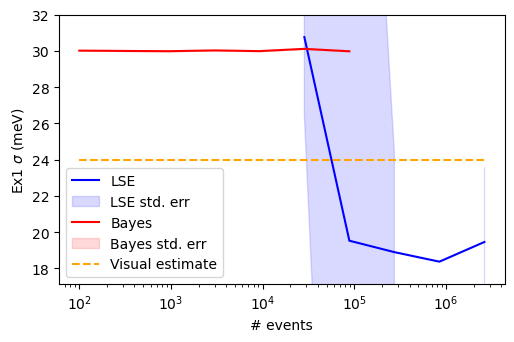

In [141]:
parameter_no = 8
p_conv_plot(parameter_no, param_name='Ex1 $\sigma$ (meV)', savename='arcsFigs/arcs_ex1_sigma.png', correct=24)
#p_conv_plot(parameter_no, LSE=False)

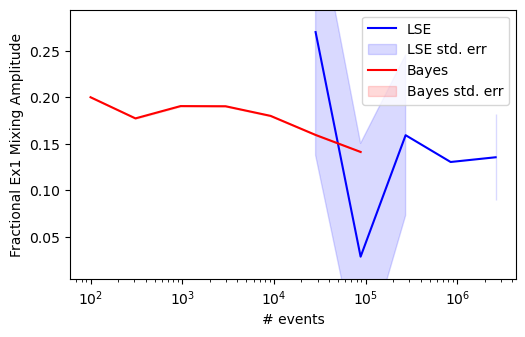

In [142]:
parameter_no = 15
p_conv_plot(parameter_no, param_name='Fractional Ex1 Mixing Amplitude', savename='arcsFigs/arcs_ex1_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Second Excitation Line Parameters

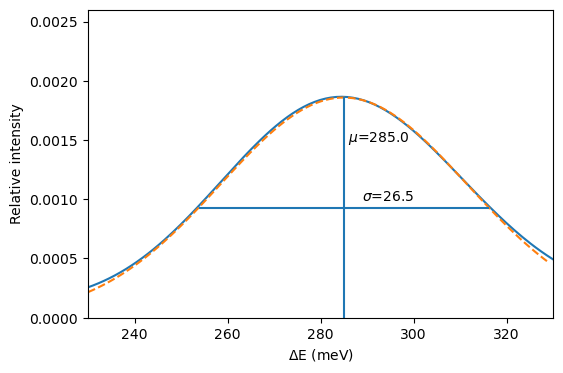

In [143]:
mu=285.0
sig=26.5
norm=8.1
ht=0.00186

r1=230
r2=330

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex2.png', dpi=600, bbox_inches='tight')
plt.show()

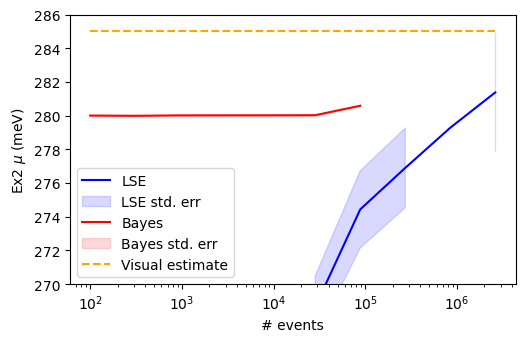

In [144]:
parameter_no = 2
p_conv_plot(parameter_no, param_name='Ex2 $\mu$ (meV)', savename='arcsFigs/arcs_ex2_mu.png', correct=285.0, ylims=[270, 286])
#p_conv_plot(parameter_no, LSE=False)

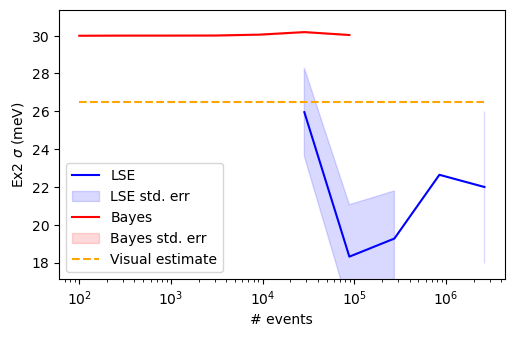

In [145]:
parameter_no = 9
p_conv_plot(parameter_no, param_name='Ex2 $\sigma$ (meV)', savename='arcsFigs/arcs_ex2_sigma.png', correct=26.5)
#p_conv_plot(parameter_no, LSE=False)

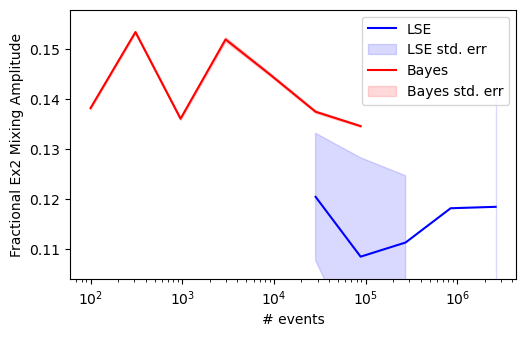

In [146]:
parameter_no = 16
p_conv_plot(parameter_no, param_name='Fractional Ex2 Mixing Amplitude', savename='arcsFigs/arcs_ex2_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Third Excitation Line Parameters

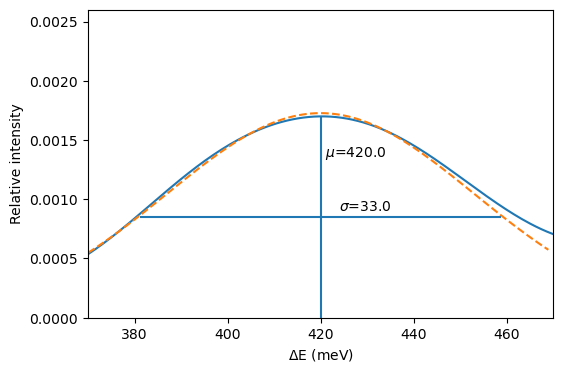

In [147]:
window_mu=420.0
mu=420.0
sig=33.0
norm=7.0
ht=0.0017

r1=window_mu-50
r2=window_mu+50

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex3.png', dpi=600, bbox_inches='tight')
plt.show()

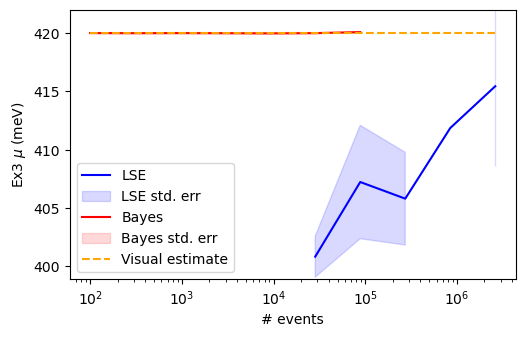

In [148]:
parameter_no = 3
p_conv_plot(parameter_no, param_name='Ex3 $\mu$ (meV)', savename='arcsFigs/arcs_ex3_mu.png', correct=420.0)
#p_conv_plot(parameter_no, LSE=False)

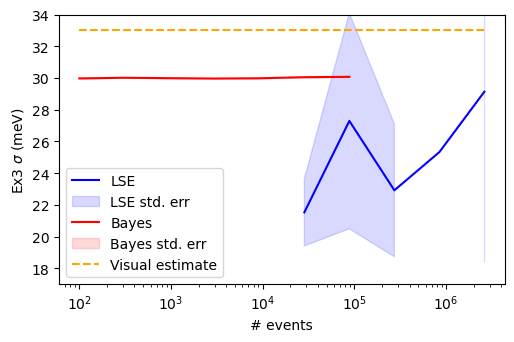

In [149]:
parameter_no = 10
p_conv_plot(parameter_no, param_name='Ex3 $\sigma$ (meV)', savename='arcsFigs/arcs_ex3_sigma.png', correct=33.0, ylims=[17, 34])
#p_conv_plot(parameter_no, LSE=False)

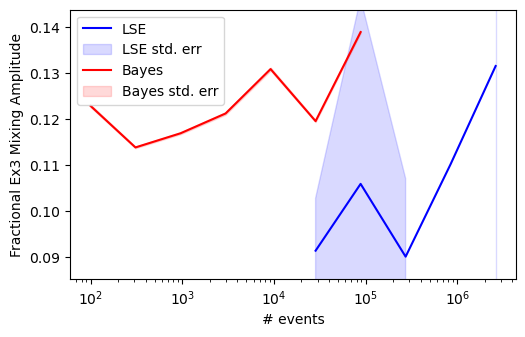

In [150]:
parameter_no = 17
p_conv_plot(parameter_no, param_name='Fractional Ex3 Mixing Amplitude', savename='arcsFigs/arcs_ex3_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Fourth Excitation Line Parameters

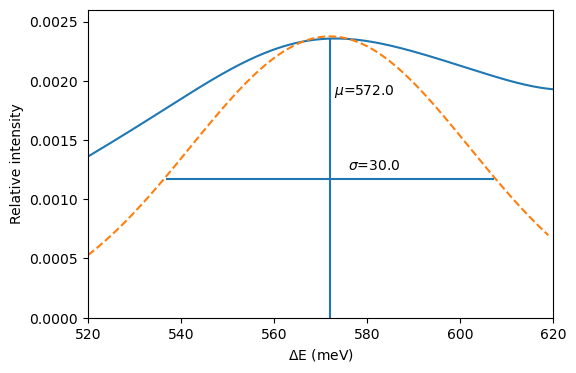

In [168]:
window_mu=570.0
mu=window_mu+2
sig=30.0
norm=5.6
ht=0.00235

r1=window_mu-50
r2=window_mu+50

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex4.png', dpi=600, bbox_inches='tight')
plt.show()

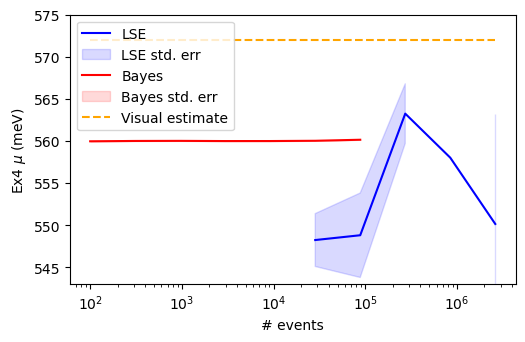

In [158]:
parameter_no = 4
p_conv_plot(parameter_no, param_name='Ex4 $\mu$ (meV)', savename='arcsFigs/arcs_ex4_mu.png', correct=572.0, ylims=[543, 575])
#p_conv_plot(parameter_no, LSE=False)

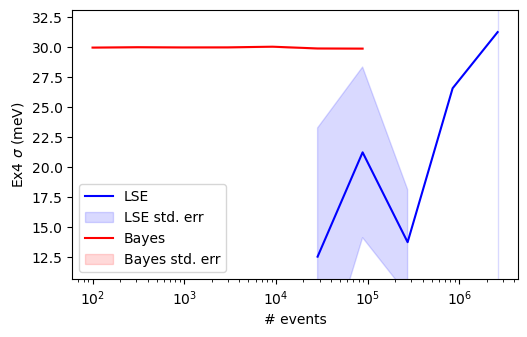

In [159]:
parameter_no = 11
p_conv_plot(parameter_no, param_name='Ex4 $\sigma$ (meV)', savename='arcsFigs/arcs_ex4_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

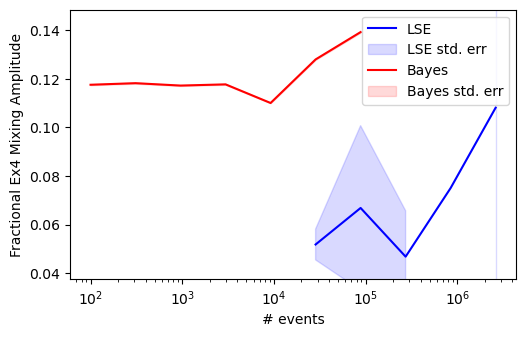

In [160]:
parameter_no = 18
p_conv_plot(parameter_no, param_name='Fractional Ex4 Mixing Amplitude', savename='arcsFigs/arcs_ex4_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### First Background Term Parameters 

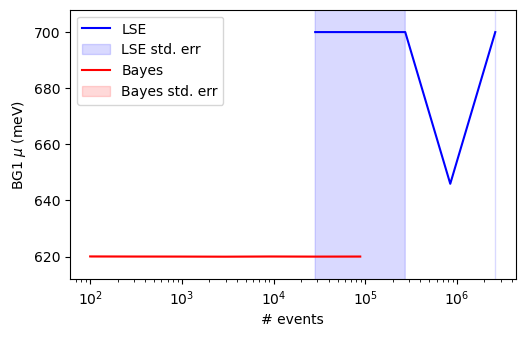

In [161]:
parameter_no = 5
p_conv_plot(parameter_no, param_name='BG1 $\mu$ (meV)', savename='arcsFigs/arcs_BG1_mu.png')
#p_conv_plot(parameter_no, LSE=False)

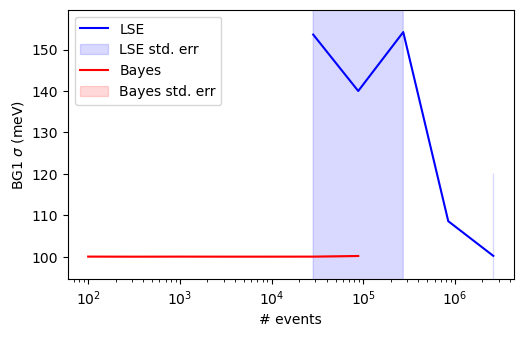

In [162]:
parameter_no = 12
p_conv_plot(parameter_no, param_name='BG1 $\sigma$ (meV)', savename='arcsFigs/arcs_BG1_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

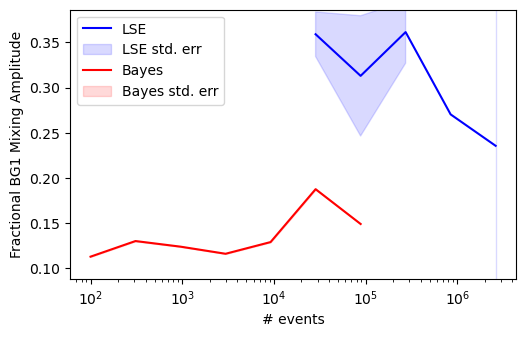

In [163]:
parameter_no = 19
p_conv_plot(parameter_no, param_name='Fractional BG1 Mixing Amplitude', savename='arcsFigs/arcs_BG1_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Second Background Term Parameters

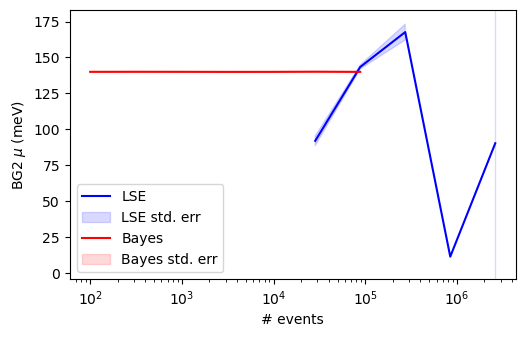

In [164]:
parameter_no = 6
p_conv_plot(parameter_no, param_name='BG2 $\mu$ (meV)', savename='arcsFigs/arcs_BG2_mu.png')
#p_conv_plot(parameter_no, LSE=False)

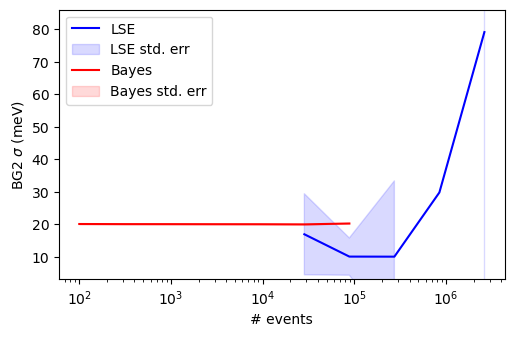

In [165]:
parameter_no = 13
p_conv_plot(parameter_no, param_name='BG2 $\sigma$ (meV)', savename='arcsFigs/arcs_BG2_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

The weight of the second background term is computed from 1-sum(other_weights) so it has no individual parameter.

## Important Questions and Possible Answers

1. Why does the parameter noise obviously exceed the reported variance for the MCMC parameters?

Probably because the random subsample of events is at each step random.  The variance is the *statistical* variance as sampled by MCMC within the data set, whilst the subsampling of the events for low numbers of events provides a systematic shift of that parameter space from analysis to analysis.  The correct variance would probably be obtained by re-subsampling many times and computing the mean and standard error of the obtained parameters.  This is going to be very slow and would require a cluster job in the future to do that work.

2. Why does the variance on some LSE parameters increase with increasing events?

Probably because the LSE is unstable with so many parameters, and it is getting stuck in a local optimum.  If you look at some of the parameters the stated variances for these parameters are enormous, so the LSE estimates from the chi-squared surface curvature are probably wrong.  Since many of the parameter values are so close to those obtained from MCMC I suspect that monte-carlo sampling the LSE parameter space as described above might yield more realistic parameter variances.
